# Predict weekly data, single city (Bayesian Structural Time-series Modelling)

In [2]:
import os
from pathlib import Path
from causalimpact import CausalImpact


import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
import zipfile


iskaggle = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "")
if iskaggle:
    path = Path("../rohanrao/air-quality-data-in-india")
else:
    full_path = Path("rohanrao/air-quality-data-in-india")
    owner_slug = str(full_path).split("/")[0]
    dataset_slug = str(full_path).split("/")[1]
    path = Path(dataset_slug)
    if not path.exists():
        import zipfile, kaggle

        kaggle.api.datasets_download(owner_slug=owner_slug, dataset_slug=dataset_slug)
        zipfile.ZipFile(f"{dataset_slug}.zip").extractall(dataset_slug)
    else:
        print(f"Path {path} exists")

Path air-quality-data-in-india exists


In [4]:
import torch, numpy as np, pandas as pd

/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option("display.width", 140)

In [6]:
df = pd.read_csv(path / "city_day.csv")
df

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,Visakhapatnam,2020-06-27,15.02,50.94,7.68,25.06,19.54,12.47,0.47,8.55,23.30,2.24,12.07,0.73,41.0,Good
29527,Visakhapatnam,2020-06-28,24.38,74.09,3.42,26.06,16.53,11.99,0.52,12.72,30.14,0.74,2.21,0.38,70.0,Satisfactory
29528,Visakhapatnam,2020-06-29,22.91,65.73,3.45,29.53,18.33,10.71,0.48,8.42,30.96,0.01,0.01,0.00,68.0,Satisfactory
29529,Visakhapatnam,2020-06-30,16.64,49.97,4.05,29.26,18.80,10.03,0.52,9.84,28.30,0.00,0.00,0.00,54.0,Satisfactory


In [7]:
df.dtypes

City           object
Date           object
PM2.5         float64
PM10          float64
NO            float64
NO2           float64
NOx           float64
NH3           float64
CO            float64
SO2           float64
O3            float64
Benzene       float64
Toluene       float64
Xylene        float64
AQI           float64
AQI_Bucket     object
dtype: object

In [8]:
df.Date = pd.to_datetime(df.Date)
df.dtypes

City                  object
Date          datetime64[ns]
PM2.5                float64
PM10                 float64
NO                   float64
NO2                  float64
NOx                  float64
NH3                  float64
CO                   float64
SO2                  float64
O3                   float64
Benzene              float64
Toluene              float64
Xylene               float64
AQI                  float64
AQI_Bucket            object
dtype: object

In [9]:
df.isna().sum()

City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64

In [10]:
df.describe(include=(np.number))

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,24933.000000,18391.000000,25949.000000,25946.000000,25346.000000,19203.000000,27472.000000,25677.000000,25509.000000,23908.000000,21490.000000,11422.000000,24850.000000
mean,67.450578,118.127103,17.574730,28.560659,32.309123,23.483476,2.248598,14.531977,34.491430,3.280840,8.700972,3.070128,166.463581
std,64.661449,90.605110,22.785846,24.474746,31.646011,25.684275,6.962884,18.133775,21.694928,15.811136,19.969164,6.323247,140.696585
min,0.040000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,13.000000
25%,28.820000,56.255000,5.630000,11.750000,12.820000,8.580000,0.510000,5.670000,18.860000,0.120000,0.600000,0.140000,81.000000
50%,48.570000,95.680000,9.890000,21.690000,23.520000,15.850000,0.890000,9.160000,30.840000,1.070000,2.970000,0.980000,118.000000
75%,80.590000,149.745000,19.950000,37.620000,40.127500,30.020000,1.450000,15.220000,45.570000,3.080000,9.150000,3.350000,208.000000
max,949.990000,1000.000000,390.680000,362.210000,467.630000,352.890000,175.810000,193.860000,257.730000,455.030000,454.850000,170.370000,2049.000000


In [11]:
df.describe(include=[object])

,City,AQI_Bucket
count,29531,24850
unique,26,6
top,Ahmedabad,Moderate
freq,2009,8829


In [12]:
delhi_df = df[df["City"] == "Delhi"]
delhi_df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
10229,Delhi,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe
10230,Delhi,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0,Severe
10231,Delhi,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0,Moderate
10232,Delhi,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0,Very Poor
10233,Delhi,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0,Very Poor


In [13]:
delhi_df.isna().sum()

City            0
Date            0
PM2.5           2
PM10           77
NO              2
NO2             2
NOx             0
NH3             9
CO              0
SO2           110
O3             84
Benzene         0
Toluene         0
Xylene        781
AQI            10
AQI_Bucket     10
dtype: int64

In [14]:
modes = delhi_df.mode().iloc[0]
modes

City                        Delhi
Date          2015-01-01 00:00:00
PM2.5                       42.06
PM10                        60.15
NO                          14.64
NO2                         38.55
NOx                         20.45
NH3                         31.36
CO                            0.0
SO2                          9.36
O3                          34.75
Benzene                      1.88
Toluene                       0.0
Xylene                        0.0
AQI                         123.0
AQI_Bucket                   Poor
Name: 0, dtype: object

In [15]:
delhi_df.fillna(modes, inplace=True)

/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.9/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [16]:
print(delhi_df.isna().sum())

City          0
Date          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
Xylene        0
AQI           0
AQI_Bucket    0
dtype: int64


In [17]:
delhi_df_weekly = delhi_df.set_index(keys=["Date"]).resample("w").mean()
delhi_df_weekly.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
Date,,,,,,,,,,,,,
2015-01-04,184.605000,312.817500,45.497500,34.120000,73.825000,66.397500,11.722500,5.795000,29.180000,8.270000,16.222500,4.865000,347.000000
2015-01-11,196.005714,337.294286,21.997143,41.187143,49.000000,133.794286,10.171429,4.435714,32.418571,4.744286,9.361429,4.550000,358.428571
2015-01-18,187.650000,311.988571,36.822857,49.240000,67.434286,138.238571,10.181429,5.451429,35.515714,7.085714,15.117143,3.720000,360.000000
2015-01-25,156.357143,217.318571,15.000000,24.634286,34.927143,74.578571,9.458571,6.518571,15.777143,3.674286,8.230000,2.967143,326.142857
2015-02-01,162.784286,234.240000,25.285714,37.278571,49.137143,63.970000,10.837143,6.471429,17.501429,4.037143,8.560000,2.982857,324.142857


In [18]:
delhi_df_daily = delhi_df.set_index(keys=["Date"]).resample("D").mean()
delhi_df_daily.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
Date,,,,,,,,,,,,,
2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0
2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0
2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0
2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0
2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0


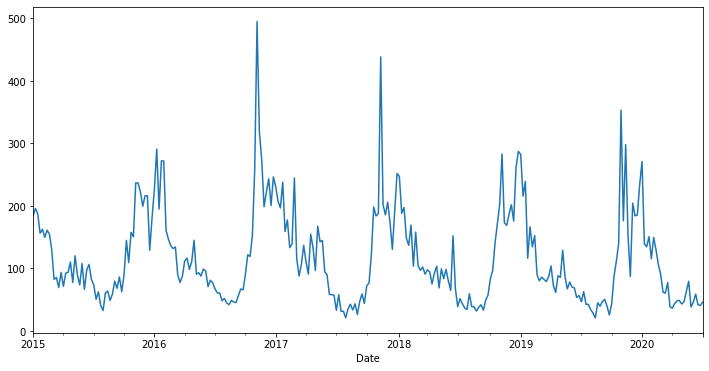

In [19]:
delhi_df_weekly["PM2.5"].plot(figsize=(12, 6))
plt.show()

<AxesSubplot:xlabel='Date'>

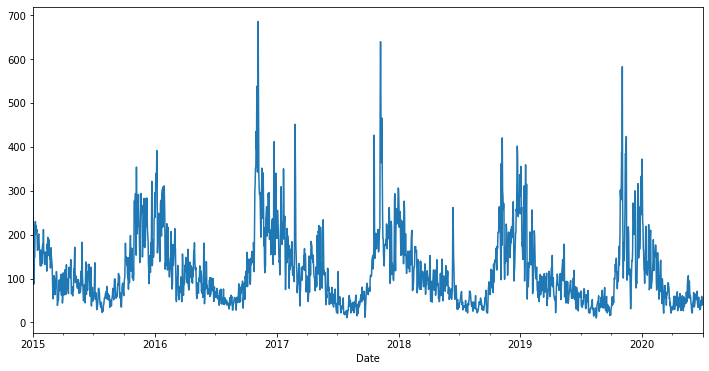

In [20]:
delhi_df_daily["PM2.5"].plot(figsize=(12, 6))

Let's see the impact of COVID-19 on the Bangalore pollution data

In [22]:
import pprint as pp

pp.pprint(delhi_df_weekly.index[-50:].values)

array(['2019-07-28T00:00:00.000000000', '2019-08-04T00:00:00.000000000', '2019-08-11T00:00:00.000000000', '2019-08-18T00:00:00.000000000',
       '2019-08-25T00:00:00.000000000', '2019-09-01T00:00:00.000000000', '2019-09-08T00:00:00.000000000', '2019-09-15T00:00:00.000000000',
       '2019-09-22T00:00:00.000000000', '2019-09-29T00:00:00.000000000', '2019-10-06T00:00:00.000000000', '2019-10-13T00:00:00.000000000',
       '2019-10-20T00:00:00.000000000', '2019-10-27T00:00:00.000000000', '2019-11-03T00:00:00.000000000', '2019-11-10T00:00:00.000000000',
       '2019-11-17T00:00:00.000000000', '2019-11-24T00:00:00.000000000', '2019-12-01T00:00:00.000000000', '2019-12-08T00:00:00.000000000',
       '2019-12-15T00:00:00.000000000', '2019-12-22T00:00:00.000000000', '2019-12-29T00:00:00.000000000', '2020-01-05T00:00:00.000000000',
       '2020-01-12T00:00:00.000000000', '2020-01-19T00:00:00.000000000', '2020-01-26T00:00:00.000000000', '2020-02-02T00:00:00.000000000',
       '2020-02-09T00:00:00

In [23]:
covid_start_date = pd.to_datetime("2020-01-26")
covid_end_date = pd.to_datetime("2020-03-29")

pre_period = [
    str(np.min(delhi_df_weekly.index)),
    str(covid_start_date),
]
post_period = [
    str(covid_end_date),
    str(np.max(delhi_df_weekly.index)),
]
pre_period[:5]

['2015-01-04 00:00:00', '2020-01-26 00:00:00']

In [27]:
delhi_df_weekly.columns

Index(['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI'], dtype='object')

In [31]:
pollution_columns = ["PM2.5", "PM10", "O3", "NO2", "SO2"]

fit_method_list = ["vi", "hmc"]
causal_impact_list = []
for fit_method in fit_method_list:
    for pollution_column in pollution_columns:
        print(
            f"\n\nGenerating causal impact for {pollution_column} with fit method: {fit_method}"
        )
        causal_impact_list.append(
            CausalImpact(
                delhi_df_weekly[pollution_column],
                pre_period=pre_period,
                post_period=post_period,
                model_args={"nseasons": 52, "fit_method": fit_method},
            )
        )



Generating causal impact for PM2.5 with fit method: vi


Generating causal impact for PM10 with fit method: vi


Generating causal impact for O3 with fit method: vi


Generating causal impact for NO2 with fit method: vi


Generating causal impact for SO2 with fit method: vi


Generating causal impact for PM2.5 with fit method: hmc


/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.9/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '




Generating causal impact for PM10 with fit method: hmc


/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.9/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '




Generating causal impact for O3 with fit method: hmc


/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.9/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '




Generating causal impact for NO2 with fit method: hmc


/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.9/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '




Generating causal impact for SO2 with fit method: hmc


/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.9/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [32]:
for fit_method in fit_method_list:

    for causal_impact, pollution_column in zip(causal_impact_list, pollution_columns):
        print(f"Causal impact for {pollution_column} with fit method: {fit_method}")
        print(causal_impact.summary())

Causal impact for PM2.5 with fit method: vi
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    48.06              720.95
Prediction (s.d.)         99.47 (11.74)      1492.02 (176.14)
95% CI                    [75.85, 121.88]    [1137.75, 1828.22]

Absolute effect (s.d.)    -51.4 (11.74)      -771.07 (176.14)
95% CI                    [-73.82, -27.79]   [-1107.27, -416.8]

Relative effect (s.d.)    -51.68% (11.81%)   -51.68% (11.81%)
95% CI                    [-74.21%, -27.94%] [-74.21%, -27.94%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Causal impact for PM10 with fit method: vi
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    117.46             1761.93
Prediction (s.d.)         220.12 (21.38)     3301.74 (320.72)
95% CI                    [177.9



Plot of causal impact for PM2.5 with fit method: vi


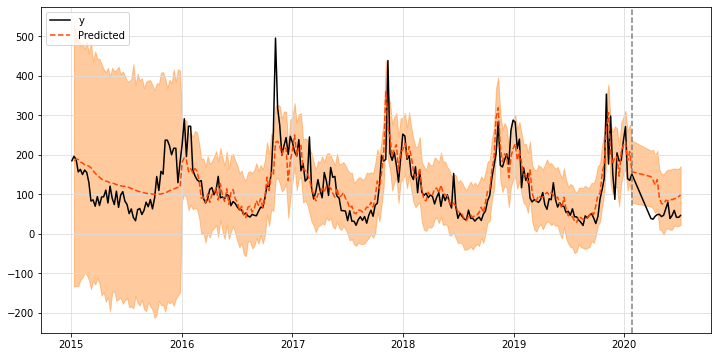



Plot of causal impact for PM10 with fit method: vi


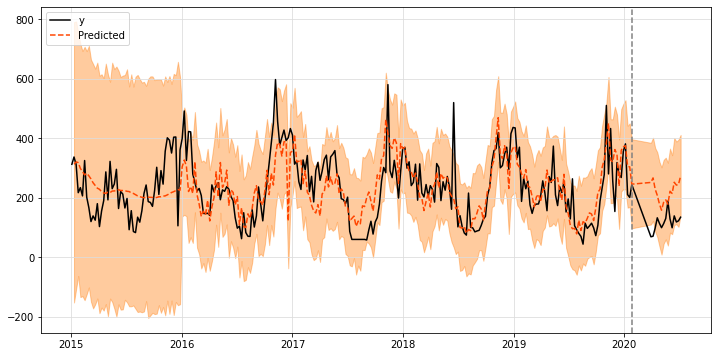



Plot of causal impact for O3 with fit method: vi


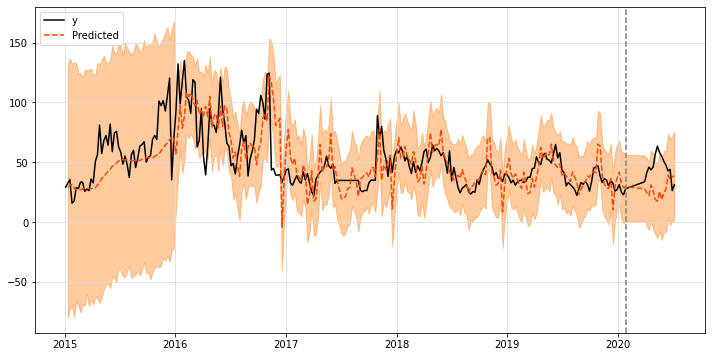



Plot of causal impact for NO2 with fit method: vi


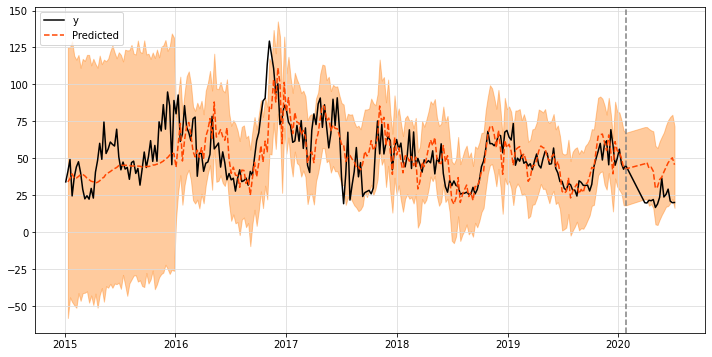



Plot of causal impact for SO2 with fit method: vi


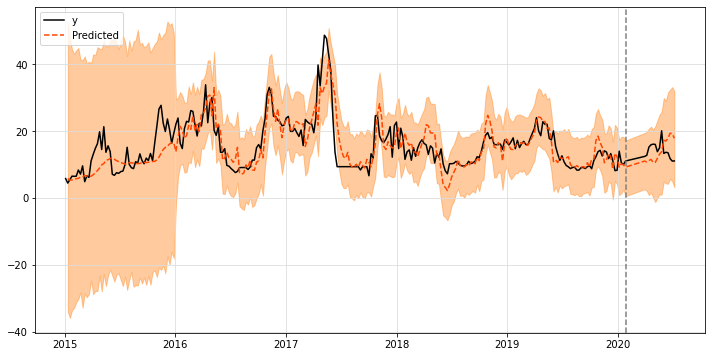



Plot of causal impact for PM2.5 with fit method: hmc


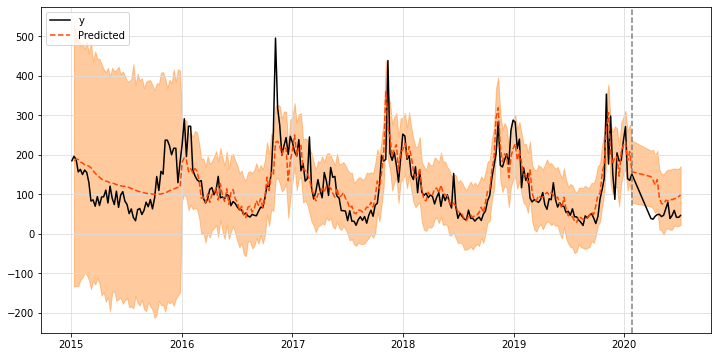



Plot of causal impact for PM10 with fit method: hmc


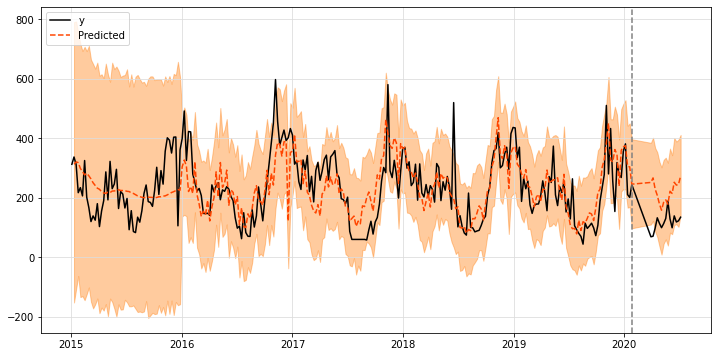



Plot of causal impact for O3 with fit method: hmc


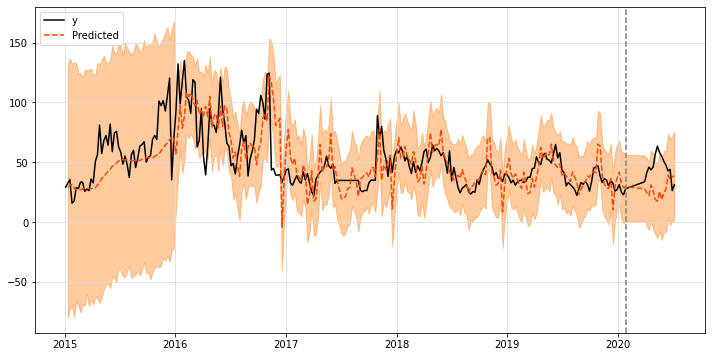



Plot of causal impact for NO2 with fit method: hmc


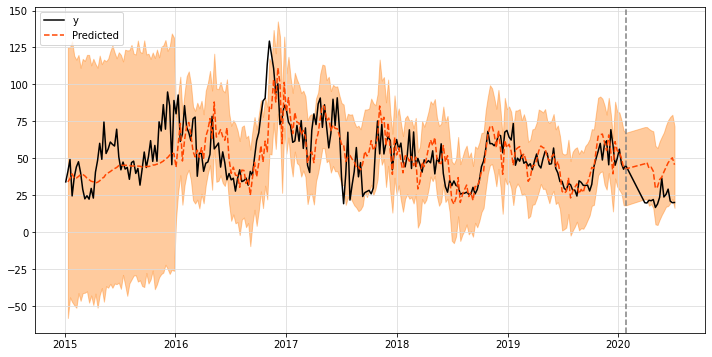



Plot of causal impact for SO2 with fit method: hmc


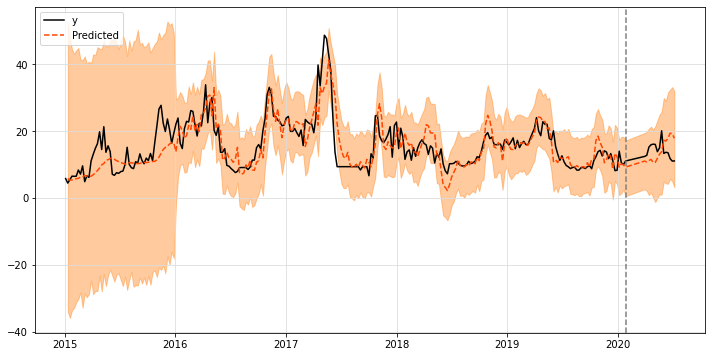

In [33]:
for fit_method in fit_method_list:

    for causal_impact, pollution_column in zip(causal_impact_list, pollution_columns):
        print(
            f"\n\nPlot of causal impact for {pollution_column} with fit method: {fit_method}"
        )
        causal_impact.plot(panels=["original"], figsize=(12, 6))

    # plt.show()

## Comparing predictions to actual values

In [34]:
causal_impact.head()

AttributeError: 'CausalImpact' object has no attribute 'head'

In [46]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-07-14,107.274970,-6.134080,75.893263,107.274970,107.274970,-74.842576,-74.842576,-74.842576,-74.842576,-74.842576,-74.842576,0.0,0.0,0.0,32.432394
1,2019-07-21,107.095897,-11.860216,71.864566,107.095897,107.096561,-77.599631,-77.599631,-77.599631,-77.599631,-77.599631,-77.599631,0.0,0.0,0.0,29.496266
2,2019-07-28,106.916824,-13.992866,70.497699,106.915611,106.922590,-80.954995,-80.954995,-80.954995,-80.954995,-80.954995,-80.954995,0.0,0.0,0.0,25.961828
3,2019-08-04,106.737750,-17.291875,59.832537,106.731842,106.750928,-83.625372,-83.625372,-83.625372,-83.625372,-83.625372,-83.625372,0.0,0.0,0.0,23.112379
4,2019-08-11,106.558677,-16.489269,64.647404,106.544915,106.583049,-82.088571,-82.088571,-82.088571,-82.088571,-82.088571,-82.088571,0.0,0.0,0.0,24.470106


In [49]:
import matplotlib.pyplot as plt



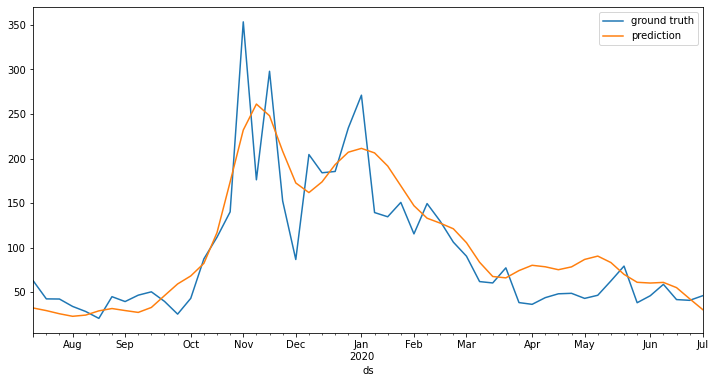

In [68]:
fig, ax = plt.subplots(figsize=(12, 6))

forecast_series = forecast.set_index(keys=["ds"]).iloc[-nobs:, :]
ground_truth_series = test.rename(columns={"Date": "ds", "PM2.5": "y"}).set_index(
    keys=["ds"]
)

ground_truth_series["y"].plot()
forecast_series["yhat"].plot()


ax.legend(["ground truth", "prediction"])

In [69]:
def calculate_RMSE(ground_truth, forecast):
    return np.sqrt(np.mean((ground_truth - forecast) ** 2))


calculate_RMSE(ground_truth_series["y"], forecast_series["yhat"])

36.34970386744316

In [ ]:
#TODO: take single year's data, make prediction, then 2 years etc. (which timespan gives best prediction?)
#TODO: try a prediction for 2023 (each Indian city)
#TODO: Plot weekly prediction for each city
# consdier location in country also

# External datasets as well - wind speed / direction & temperature
# Which method performs best with Pollution data
# Which metrics to use to find which method perform the best